In [2]:
import gym
import swingUp
import numpy as np
import numpy.random as rnd
import torch as pt
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
reload(swingUp)

<module 'swingUp' from 'C:\\Users\\sanja\\EE5940\\swingUp.py'>

# The Swing-Up Problem

In this homework we will study a classic problem of swinging up a pendulum and keeping it balanced. In this problem, forces in the range $[-1,1]$ are applied to a cart with a pendulum on it. The episode ends if one of the boundaries is reached or the pendulum swings too fast. Otherwise, it just keeps going. You recieve a reward of 1 any time the pendulum is above horizontal. You recieve a negative cost if the episode ends becauseof hitting the boundary or swinging too fast.

The code below demonstrates a basic SARSA method with a neural network for approximating the $Q$-function. This system has continuous observation and action spaces. However, for simplicity and applicability of the basic SARSA method, we are only using two actions.

In [2]:
class nnQ(pt.nn.Module):
    """
    Here is a basic neural network with for representing a policy 
    """
    
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers):
        super().__init__()
        
        InputLayer = [pt.nn.Linear(stateDim+numActions,numHiddenUnits),
                      pt.nn.ReLU()]
        
        HiddenLayers = []
        for _ in range(numLayers-1):
            HiddenLayers.append(pt.nn.Linear(numHiddenUnits,numHiddenUnits))
            HiddenLayers.append(pt.nn.ReLU())
            
        
        OutputLayer = [pt.nn.Linear(numHiddenUnits,1)]
        
        AllLayers = InputLayer + HiddenLayers + OutputLayer
        self.net = pt.nn.Sequential(*AllLayers)
        
        self.numActions = numActions
        
    def forward(self,x,a):
        x = pt.tensor(x,dtype=pt.float32) # feature
        a = pt.tensor(a, dtype=pt.int64)  # parametesw
        b = pt.nn.functional.one_hot(a,self.numActions)
        c = b.float().detach()
        y = pt.cat([x,c])
        
        return self.net(y)
        
    
class sarsaAgent:
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers,
                epsilon=.1,gamma=.9,alpha=.1):
        # These are the parameters
        self.Q = nnQ(stateDim,numActions,numHiddenUnits,numLayers)
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.numActions = numActions
        self.s_last = None
    # The action is chosen acc to eps-greedy    
    def action(self,x):t
        # This is an epsilon greedy selection (can do max also)
        # Whichever has the highest Q, perform that action
        if rnd.rand() < self.epsilon:
            a = rnd.randint(numActions)
        else:
            qBest = -np.inf
            for aTest in range(self.numActions):
                qTest = self.Q(x,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    a = aTest
        return a
    
    def update(self,s,a,r,s_next,done):
        
        # Compute the TD error, if there is enough data
        update = True
        if done:
            Q_cur = self.Q(s,a).detach().numpy()[0]
            delta = r - Q_cur
            self.s_last = None
            Q_diff = self.Q(s,a)
        elif self.s_last is not None:
            Q_next = self.Q(s,a).detach().numpy()[0]
            Q_cur = self.Q(self.s_last,self.a_last).detach().numpy()[0]
            delta = self.r_last + self.gamma * Q_next - Q_cur
            Q_diff = self.Q(self.s_last,self.a_last)
        else:
            update = False
            
        # Update the parameter via the semi-gradient method
        if update:
            self.Q.zero_grad()
            Q_diff.backward()
            for p in self.Q.parameters():
                p.data.add_(self.alpha*delta,p.grad.data)
            
            
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)


# The Simulation

Here is the simulation. It takes about an hour to run this (at least on my computer). I suggest you make yourself a very complex, luxurious sandwich while you wait. Alternatively, just decrease `maxSteps` to a more civilised value.

It doesn't learn the task perfectly, but it will do pretty well for stretches. 

Episode: 1 Total Steps: 209 , Ave. Reward: -4.837008033929793 , Episode Length: 209 Max Up-Time: 36
Episode: 2 Total Steps: 341 , Ave. Reward: -7.163094699338802 , Episode Length: 132 Max Up-Time: 64
Episode: 3 Total Steps: 402 , Ave. Reward: -7.672323726005186 , Episode Length: 61 Max Up-Time: 0
Episode: 4 Total Steps: 461 , Ave. Reward: -10.63490538619404 , Episode Length: 59 Max Up-Time: 0
Episode: 5 Total Steps: 506 , Ave. Reward: -11.247522825137162 , Episode Length: 45 Max Up-Time: 9
Episode: 6 Total Steps: 551 , Ave. Reward: -14.034546452755462 , Episode Length: 45 Max Up-Time: 0
Episode: 7 Total Steps: 611 , Ave. Reward: -8.924898692764744 , Episode Length: 60 Max Up-Time: 0
Episode: 8 Total Steps: 659 , Ave. Reward: -14.834576052390414 , Episode Length: 48 Max Up-Time: 0
Episode: 9 Total Steps: 985 , Ave. Reward: -1.721321597888963 , Episode Length: 326 Max Up-Time: 0
Episode: 10 Total Steps: 3918 , Ave. Reward: -0.0997579683578377 , Episode Length: 2933 Max Up-Time: 20
Episod

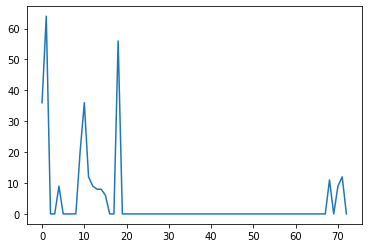

In [4]:
# This is the environment
env = swingUp.SwingUpEnv()

# For simplicity, we only consider forces of -1 and 1
numActions = 2
Actions = np.linspace(-1,1,numActions)

# This is our learning agent
gamma = .95
agent = sarsaAgent(5,numActions,20,1,epsilon=5e-2,gamma=gamma,alpha=1e-4)

maxSteps = 2e5

# This is a helper to deal with the fact that x[2] is actually an angle
x_to_y = lambda x : np.array([x[0],x[1],np.cos(x[2]),np.sin(x[2]),x[3]]) # this is dyn of the cartpole

R = []
UpTime = []

step = 0
ep = 0
while step < maxSteps:
    ep += 1
    x = env.reset() # initialize s
    C = 0.  # WHATS C
    
    done = False
    t = 1
    while not done:
        t += 1 # what is this
        step += 1
        y = x_to_y(x)
        a = agent.action(y)
        u = Actions[a:a+1]
        env.render()
        x_next,c,done,info = env.step(u)
        
        max_up_time = info['max_up_time']
        y_next = x_to_y(x_next)

        C += (1./t)*(c-C)
        agent.update(y,a,c,y_next,done)
        x = x_next
        if done:
            break
            
        if step >= maxSteps:
            break
            
        
        R.append(C)
    UpTime.append(max_up_time)
    #print('t:',ep+1,', R:',C,', L:',t-1,', G:',G,', Q:', Q_est, 'U:', max_up_time)
    print('Episode:',ep,'Total Steps:',step,', Ave. Reward:',C,', Episode Length:',t-1, 'Max Up-Time:', max_up_time)
env.close()

plt.plot(UpTime)

In each episode, the system tracks the "Maximum Up-Time", which is the longest stretch of time that the pendulum tip was above the horizontal

# Question

Implement your own controller or modify the code above. Try a different function approximation and see if you can get longer up time, learn more quickly, or more consistently. As with the code above, plot the maximum up time for each episode.

In [7]:
class nnQ_san(pt.nn.Module):
    """
    Here is a basic neural network with for representing a policy 
    """
    
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers):
        super().__init__()
        
        InputLayer = [pt.nn.Linear(stateDim+numActions,numHiddenUnits),
                      pt.nn.ReLU()]
        
        HiddenLayers = []
        for _ in range(numLayers-1):
            HiddenLayers.append(pt.nn.Linear(numHiddenUnits,numHiddenUnits))
            HiddenLayers.append(pt.nn.ReLU())
            
        
        OutputLayer = [pt.nn.Linear(numHiddenUnits,1)]
        
        AllLayers = InputLayer + HiddenLayers + OutputLayer
        self.net = pt.nn.Sequential(*AllLayers)
        
        self.numActions = numActions
        
    def forward(self,x,a):
        x = pt.tensor(x,dtype=pt.float32) # feature
        a = pt.tensor(a, dtype=pt.int64)  # parametesw
        b = pt.nn.functional.one_hot(a,self.numActions)
        c = b.float().detach()
        y = pt.cat([x,c])
        
        return self.net(y)
        
    
class sarsaAgent_san:
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers,
                epsilon=.1,gamma=.9,alpha=.1):
        # These are the parameters
        self.Q = nnQ_san(stateDim,numActions,numHiddenUnits,numLayers)
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.numActions = numActions
        self.s_last = None
    # The action is chosen acc to eps-greedy    
    def action(self,x):
        # This is an epsilon greedy selection (can do max also)
        # Whichever has the highest Q, perform that action
        if rnd.rand() < self.epsilon:
            a = rnd.randint(numActions)
        else:
            qBest = -np.inf
            for aTest in range(self.numActions):
                qTest = self.Q(x,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    a = aTest
        return a
    
    def update(self,s,a,r,s_next,done):
        
        # Compute the TD error, if there is enough data
        update = True
        if done:
            Q_cur = self.Q(s,a).detach().numpy()[0]
            delta = r - Q_cur
            self.s_last = None
            Q_diff = self.Q(s,a)
        elif self.s_last is not None:
            Q_next = self.Q(s,a).detach().numpy()[0]
            Q_cur = self.Q(self.s_last,self.a_last).detach().numpy()[0]
            delta = self.r_last + self.gamma * Q_next - Q_cur
            Q_diff = self.Q(self.s_last,self.a_last)
        else:
            update = False
            
        # Update the parameter via the semi-gradient method
        if update:
            self.Q.zero_grad()
            Q_diff.backward()
            for p in self.Q.parameters():
                p.data.add_(self.alpha*delta,p.grad.data)
            
            
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)

Episode: 1 Total Steps: 36 , Ave. Reward: -17.553926228849846 , Episode Length: 36 Max Up-Time: 0
Episode: 2 Total Steps: 73 , Ave. Reward: -17.640597146305144 , Episode Length: 37 Max Up-Time: 9
Episode: 3 Total Steps: 192 , Ave. Reward: -7.766510903013559 , Episode Length: 119 Max Up-Time: 0
Episode: 4 Total Steps: 309 , Ave. Reward: -6.150366811122324 , Episode Length: 117 Max Up-Time: 0
Episode: 5 Total Steps: 348 , Ave. Reward: -19.44556991893413 , Episode Length: 39 Max Up-Time: 8
Episode: 6 Total Steps: 502 , Ave. Reward: -3.2959486795614303 , Episode Length: 154 Max Up-Time: 0
Episode: 7 Total Steps: 533 , Ave. Reward: -25.371874349797363 , Episode Length: 31 Max Up-Time: 0
Episode: 8 Total Steps: 569 , Ave. Reward: -17.01923776030672 , Episode Length: 36 Max Up-Time: 6
Episode: 9 Total Steps: 695 , Ave. Reward: -5.35263978332681 , Episode Length: 126 Max Up-Time: 0
Episode: 10 Total Steps: 994 , Ave. Reward: -1.7368562688955893 , Episode Length: 299 Max Up-Time: 0
Episode: 11 

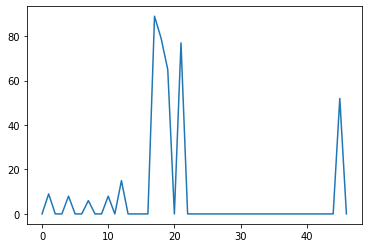

In [10]:
# Make your code here.

# This is the environment
env = swingUp.SwingUpEnv()

# For simplicity, we only consider forces of -1 and 1
numActions = 2
Actions = np.linspace(-1,1,numActions)

# This is our learning agent
gamma = .8
agent = sarsaAgent_san(5,numActions,20,1,epsilon=5e-2,gamma=gamma,alpha=1e-4)

maxSteps = 2e4

# This is a helper to deal with the fact that x[2] is actually an angle
x_to_y = lambda x : np.array([x[0],x[1],np.cos(x[2]),np.sin(x[2]),x[3]]) # this is dyn of the cartpole

R = []
UpTime = []

step = 0
ep = 0
while step < maxSteps:
    ep += 1
    x = env.reset() # initialize s
    C = 0.  # WHATS C
    
    done = False
    t = 1
    while not done:
        t += 1 # what is this
        step += 1
        y = x_to_y(x)
        a = agent.action(y)
        u = Actions[a:a+1]
        env.render()
        x_next,c,done,info = env.step(u)
        
        max_up_time = info['max_up_time']
        y_next = x_to_y(x_next)

        C += (1./t)*(c-C)
        agent.update(y,a,c,y_next,done)
        x = x_next
        if done:
            break
            
        if step >= maxSteps:
            break
            
        
        R.append(C)
    UpTime.append(max_up_time)
    #print('t:',ep+1,', R:',C,', L:',t-1,', G:',G,', Q:', Q_est, 'U:', max_up_time)
    print('Episode:',ep,'Total Steps:',step,', Ave. Reward:',C,', Episode Length:',t-1, 'Max Up-Time:', max_up_time)
env.close()

plt.plot(UpTime)